# Apply neuropower to simulated dataset

In this notebook, I will simulate data and see if we can estimate the effect size with neuropower.

In [1]:
import matplotlib
% matplotlib inline
import numpy as np
import scipy
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate
from __future__ import print_function, division
import BUM
import neuropower
import cluster
import peakdistribution
import os
import math
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
from nipype.interfaces import fsl
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from palettable.colorbrewer.qualitative import Paired_12
import scipy.stats as stats
from nipy.algorithms.statistics.empirical_pvalue import NormalEmpiricalNull


In [2]:
os.chdir("/Users/Joke/Documents/Onderzoek/Studie_7_neuropower_improved/WORKDIR/")

##  Simulate data

/Users/Joke/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


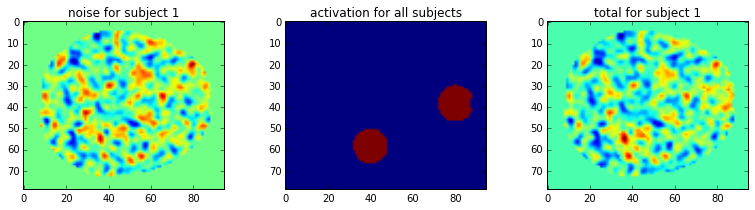

In [11]:
effectsize = 1

smooth_FWHM = 3
smooth_sigma = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
dimensions = (50,50,50)
positions = np.array([[60,40,40],
                   [40,80,40],
                   [50,30,60]])
amplitudes = np.array([1.,1.,1.])
width = 10.
seed=123
mask = nib.load("0mask.nii")
nsub=15

noise = surrogate_3d_dataset(n_subj=nsub, shape=dimensions, mask=mask, 
                             sk=smooth_sigma,noise_level=1.0, 
                             width=5.0,out_text_file=None, 
                             out_image_file=None, seed=seed)
signal = surrogate_3d_dataset(n_subj=nsub, shape=dimensions, mask=mask, 
                             sk=smooth_sigma,noise_level=0.0, pos=positions, 
                             ampli=amplitudes, width=width,out_text_file=None, 
                             out_image_file=None, seed=seed)
low_values_indices = signal < 0.1
signal[low_values_indices] = 0
high_values_indices = signal > 0
signal[high_values_indices] = effectsize
data = noise+signal

fig,axs=plt.subplots(1,3,figsize=(13,3))
fig.subplots_adjust(hspace = .5, wspace=0.3)
axs=axs.ravel()
axs[0].imshow(noise[1,:,:,40])
axs[0].set_title("noise for subject 1")
axs[1].imshow(signal[1,:,:,40])
axs[1].set_title("activation for all subjects")
axs[2].imshow(data[1,:,:,40])
axs[2].set_title("total for subject 1")
fig.show()


In [12]:
data = data.transpose((1,2,3,0))
img=nib.Nifti1Image(data,np.eye(4))
img.to_filename(os.path.join("simulated_dataset.nii.gz"))

##  Analyze simulated data and show results

In [14]:
model=fsl.L2Model(num_copes=nsub)
model.run()
flameo=fsl.FLAMEO(cope_file='simulated_dataset.nii.gz', 
                  cov_split_file='design.grp', 
                  design_file='design.mat',
                  t_con_file='design.con',
                  mask_file='0mask.nii',
                  run_mode='ols',
                  terminal_output='none')
flameo.run()

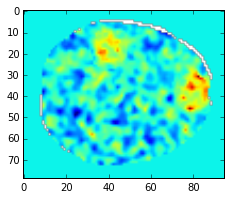

In [15]:
spm = nib.load("stats/tstat1.nii.gz").get_data()

plt.figure(figsize=(13,3))
plt.imshow(spm[:,:,40])
plt.show()


#### Distribution of T-values

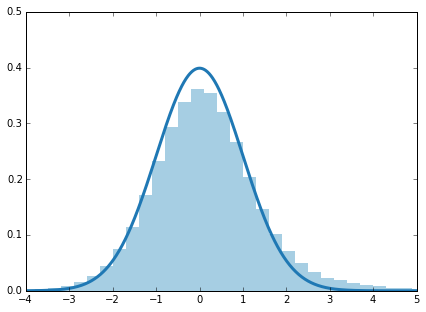

In [17]:
ps = spm.flatten()
ps = [x for x in ps if x!=0]
xn = np.arange(-10,40,0.01)
twocol = Paired_12.mpl_colors
plt.figure(figsize=(7,5))
plt.hist(ps,lw=0,facecolor=twocol[0],normed=True,bins=np.arange(-5,40,0.3),label="observed distribution")
plt.xlim([-4,5])
plt.ylim([0,0.5])
plt.plot(xn,stats.norm.pdf(xn),color=twocol[1],lw=3,label="null distribution")
plt.show()


## Extract peaks, compute p-values (with CS-distribution), show distribution of peaks and p-values

In [18]:
mypeaks = cluster.cluster(spm)
pvalues = peakdistribution.peakp(mypeaks.peak.tolist())
pvalues = [max(10**(-6),t) for t in pvalues]
mypeaks['pval'] = pvalues

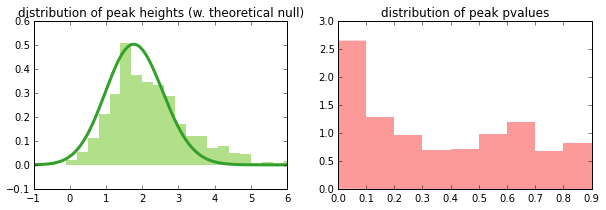

In [19]:
f,(plt1,plt2) = plt.subplots(1,2,figsize=(10,3))
plt1.hist(mypeaks['peak'].tolist(),lw=0,facecolor=twocol[2],bins=np.arange(-1,10,0.3),normed=True)
plt1.plot(xn,[peakdistribution.peakdens3D(p,1) for p in xn],color=twocol[3],lw=3)
plt1.set_xlim([-1,6])
plt1.set_title("distribution of peak heights (w. theoretical null)")
plt2.hist(mypeaks['pval'].tolist(),lw=0,facecolor=twocol[4],bins=np.arange(0,1,0.1),normed=True)
plt2.set_title("distribution of peak pvalues")
plt.show()

##  Apply model to find alternative distribution, show fit of mixture

In [20]:
bum = BUM.bumOptim(mypeaks['pval'].tolist(),starts=10)
modelfit = neuropower.TFpeakfit(mypeaks['peak'].tolist(),0.8)

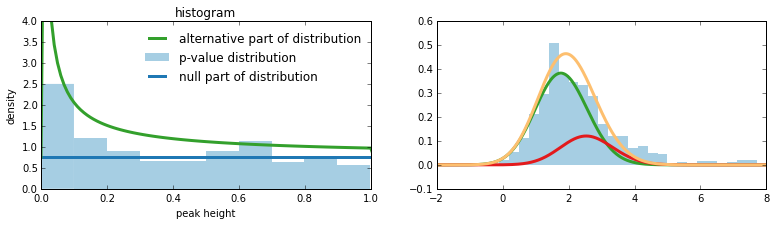

In [21]:
twocol = Paired_12.mpl_colors
xn = np.arange(-10,10,0.01)
f,(plt1,plt2) = plt.subplots(1,2,figsize=(13,3))
plt.subplots_adjust(hspace = 1, wspace=0.2)
plt1.hist(mypeaks['pval'].tolist(),lw=0,facecolor=twocol[0],normed=True,label="p-value distribution")
plt1.hlines(1-bum["pi1"],0,1,color=twocol[1],lw=3,label="null part of distribution")
plt1.plot(xn,stats.beta.pdf(xn,bum["a"],1)+1-bum["pi1"],color=twocol[3],lw=3,label="alternative part of distribution")
plt1.set_xlim([0,1])
plt1.set_ylim([0,4])
plt1.set_title("histogram")
plt1.set_xlabel("peak height")
plt1.set_ylabel("density")
plt1.legend(loc="upper right",frameon=False)

plt2.hist(mypeaks['peak'].tolist(),lw=0,bins=np.arange(-1,10,0.3),facecolor=twocol[0],normed=True,label="statistics distribution")
plt2.plot(xn,[(1-bum["pi1"])*peakdistribution.peakdens3D(p,1) for p in xn],color=twocol[3],lw=3,label="null distribution")
plt2.plot(xn,[bum["pi1"]*peakdistribution.peakdens3D(p-modelfit['delta'],1) for p in xn],color=twocol[5],lw=3,label="alternative distribution")
plt2.plot(xn,neuropower.mixprobdens(modelfit['delta'],bum['pi1'],xn),color=twocol[6],lw=3)
plt2.set_xlim([-2,8])
plt.show()


In [22]:
print(modelfit)
print(bum)

{'maxloglikelihood': array([ 1838.68709821]), 'delta': array([ 0.7688912])}
{'a': 0.21234729009338582, 'pi1': 0.2393982821084476, 'maxloglikelihood': -408.03167494694043, 'lambda': 0.69606112046915802}
